In [124]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

image_height = 28
image_width  = 28
num_labels = 11
num_channels = 1 # grayscale

In [125]:
pickle_file = 'svhn_tf.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train']
    valid_dataset = save['valid']
    test_dataset = save['test']
    del save  # hint to help gc free up memory

In [126]:
def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, image_height, image_width, num_channels)).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset['data'], train_dataset['labels'])
valid_dataset, valid_labels = reformat(valid_dataset['data'], valid_dataset['labels'])
test_dataset, test_labels = reformat(test_dataset['data'], test_dataset['labels'])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (33402, 28, 28, 1) (33402, 6)
Validation set (2000, 28, 28, 1) (2000, 6)
Test set (13068, 28, 28, 1) (13068, 6)


In [127]:
import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
for i in range(20,40):    
    print(train_labels[i])

[2 0 0 0 0 0]
[5 1 5 0 0 0]
[4 7 0 0 0 0]
[8 9 0 0 0 0]
[ 6 10  1  0  0  0]
[2 4 0 0 0 0]
[5 6 0 0 0 0]
[5 2 0 0 0 0]
[1 3 2 0 0 0]
[1 4 0 0 0 0]
[6 3 8 0 0 0]
[4 3 0 0 0 0]
[1 4 0 0 0 0]
[4 2 0 0 0 0]
[6 0 0 0 0 0]
[4 4 0 0 0 0]
[1 1 0 0 0 0]
[1 7 0 0 0 0]
[3 1 0 0 0 0]
[ 2 10  0  0  0  0]


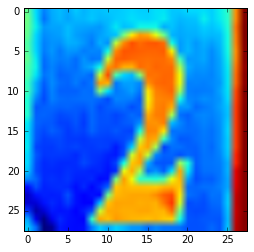

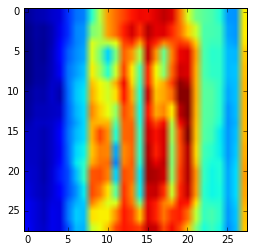

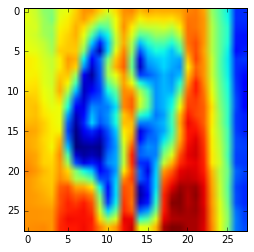

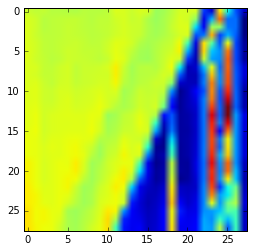

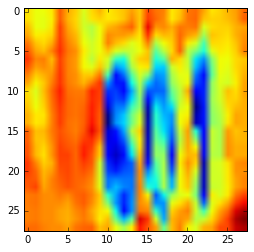

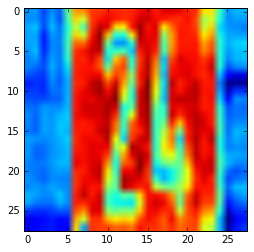

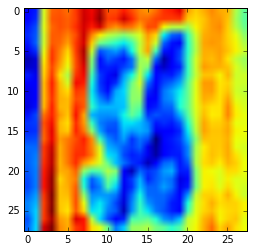

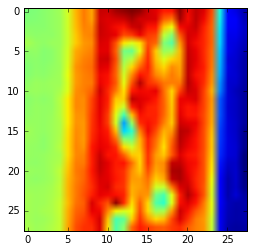

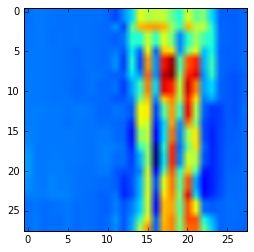

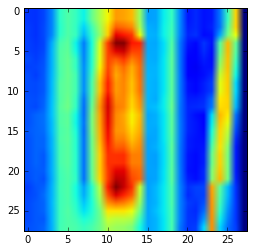

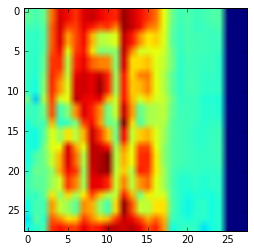

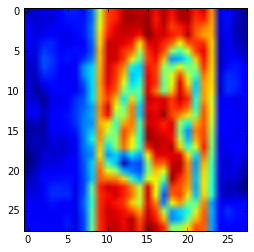

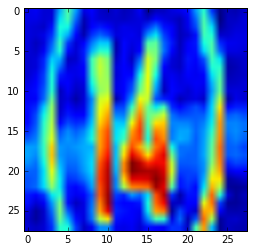

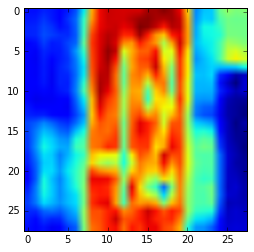

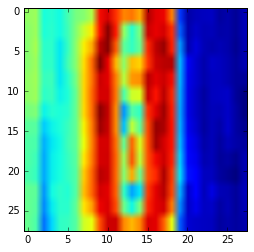

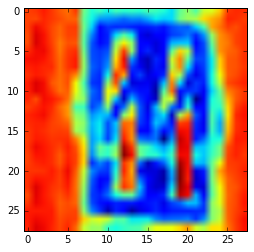

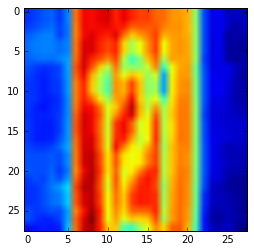

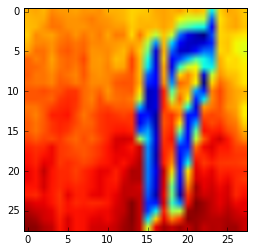

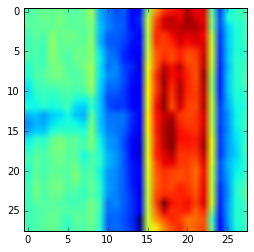

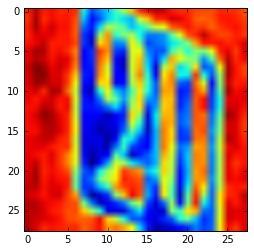

In [128]:
for i in range(20,40): 
    plt.figure()
    plt.imshow(train_dataset[i,:,:,0])

# Original Setup

In [175]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 256

graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros([depth]))

    flayer1_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer2_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer2_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer3_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer4_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer5_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))    
    
    softmax1_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax2_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax3_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))        
    
    # Convolutions
    def conv2d(x, W, b, strides=1):
        conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='SAME')        
        conv = tf.nn.bias_add(conv,b)
        return tf.nn.relu(conv)

    # Pooling
    def maxpool2d(x, k=2, s=2):
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
    
      # Model: Deep neural network .
    def model(data):  
        hidden = maxpool2d(conv2d(data, layer1_weights, layer1_biases))
        hidden = maxpool2d(conv2d(hidden, layer2_weights, layer2_biases))
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden1 = tf.nn.relu(tf.matmul(reshape, flayer1_weights) + flayer1_biases)
        hidden2 = tf.nn.relu(tf.matmul(reshape, flayer2_weights) + flayer2_biases)
        hidden3 = tf.nn.relu(tf.matmul(reshape, flayer3_weights) + flayer3_biases)
        hidden4 = tf.nn.relu(tf.matmul(reshape, flayer4_weights) + flayer4_biases)
        hidden5 = tf.nn.relu(tf.matmul(reshape, flayer5_weights) + flayer5_biases)
        
        log1 = tf.matmul(hidden1, softmax1_weights) + softmax1_biases
        log2 = tf.matmul(hidden2, softmax2_weights) + softmax2_biases
        log3 = tf.matmul(hidden3, softmax3_weights) + softmax3_biases
        log4 = tf.matmul(hidden4, softmax4_weights) + softmax4_biases
        log5 = tf.matmul(hidden5, softmax5_weights) + softmax5_biases
        
        return log1, log2, log3, log4, log5

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4]))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_logits = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(train_logits[0]),\
                      tf.nn.softmax(train_logits[1]), tf.nn.softmax(train_logits[2]),\
                      tf.nn.softmax(train_logits[3]), tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]),\
                      tf.nn.softmax(valid_logits[1]), tf.nn.softmax(valid_logits[2]),\
                      tf.nn.softmax(valid_logits[3]), tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]),\
                      tf.nn.softmax(test_logits[1]), tf.nn.softmax(test_logits[2]),\
                      tf.nn.softmax(test_logits[3]), tf.nn.softmax(test_logits[4])])

In [176]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [177]:
num_steps = 30001
from sklearn.metrics import f1_score

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:5]))
#            print('Minibatch F1 %.1f%%' % f1_score(batch_labels[:,1:6], predictions))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels[:,0:5]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
    
    # Creates a saver.
    saver0 = tf.train.Saver()
    saver0.save(session, 'saver1_ckpt')
    

Initialized
Minibatch loss at step 0: 17.243177
Minibatch accuracy: 2.5%
Validation accuracy: 3.4%
Minibatch loss at step 50: 5.841396
Minibatch accuracy: 62.5%
Validation accuracy: 53.4%
Minibatch loss at step 100: 6.038429
Minibatch accuracy: 58.8%
Validation accuracy: 53.3%
Minibatch loss at step 150: 6.065418
Minibatch accuracy: 63.8%
Validation accuracy: 53.4%
Minibatch loss at step 200: 5.782200
Minibatch accuracy: 66.2%
Validation accuracy: 53.4%
Minibatch loss at step 250: 5.560331
Minibatch accuracy: 68.8%
Validation accuracy: 53.4%
Minibatch loss at step 300: 6.466636
Minibatch accuracy: 57.5%
Validation accuracy: 51.3%
Minibatch loss at step 350: 5.797300
Minibatch accuracy: 63.8%
Validation accuracy: 54.9%
Minibatch loss at step 400: 6.212481
Minibatch accuracy: 58.8%
Validation accuracy: 54.4%
Minibatch loss at step 450: 5.206351
Minibatch accuracy: 67.5%
Validation accuracy: 51.3%
Minibatch loss at step 500: 5.842059
Minibatch accuracy: 60.0%
Validation accuracy: 53.2%
Mi

# Alternative conf. \#1

In [190]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 256
train_size = train_labels.shape[0]

graph = tf.Graph()

with graph.as_default():
    
    SEED=88
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros([depth]))

    flayer1_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer2_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer2_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer3_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer4_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer5_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01))
    flayer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))    
    
    softmax1_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax2_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax3_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))        
    
    # Convolutions
    def conv2d(x, W, b, strides=1):
        conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='SAME')        
        conv = tf.nn.bias_add(conv,b)
        return tf.nn.relu(conv)

    # Pooling
    def maxpool2d(x, k=2, s=2):
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
    
      # Model: Deep neural network .
    def model(data, train=False):
        hidden = maxpool2d(conv2d(data, layer1_weights, layer1_biases))
        hidden = maxpool2d(conv2d(hidden, layer2_weights, layer2_biases))
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden1 = tf.nn.relu(tf.matmul(reshape, flayer1_weights) + flayer1_biases)
        hidden2 = tf.nn.relu(tf.matmul(reshape, flayer2_weights) + flayer2_biases)
        hidden3 = tf.nn.relu(tf.matmul(reshape, flayer3_weights) + flayer3_biases)
        hidden4 = tf.nn.relu(tf.matmul(reshape, flayer4_weights) + flayer4_biases)
        hidden5 = tf.nn.relu(tf.matmul(reshape, flayer5_weights) + flayer5_biases)
        
        if train:
            hidden1 = tf.nn.dropout(hidden1, .9, seed=SEED)
            hidden2 = tf.nn.dropout(hidden2, .9, seed=SEED)
            hidden3 = tf.nn.dropout(hidden3, .9, seed=SEED)
            hidden4 = tf.nn.dropout(hidden4, .9, seed=SEED)
            hidden5 = tf.nn.dropout(hidden5, .9, seed=SEED)
        
        log1 = tf.matmul(hidden1, softmax1_weights) + softmax1_biases
        log2 = tf.matmul(hidden2, softmax2_weights) + softmax2_biases
        log3 = tf.matmul(hidden3, softmax3_weights) + softmax3_biases
        log4 = tf.matmul(hidden4, softmax4_weights) + softmax4_biases
        log5 = tf.matmul(hidden5, softmax5_weights) + softmax5_biases
        
        return log1, log2, log3, log4, log5

    # Training computation.
    logits = model(tf_train_dataset, train=True)
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4]))
    
    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.95)
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(logits[0]),\
                      tf.nn.softmax(logits[1]), tf.nn.softmax(logits[2]),\
                      tf.nn.softmax(logits[3]), tf.nn.softmax(logits[4])])
    
    valid_logits = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]),\
                      tf.nn.softmax(valid_logits[1]), tf.nn.softmax(valid_logits[2]),\
                      tf.nn.softmax(valid_logits[3]), tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]),\
                      tf.nn.softmax(test_logits[1]), tf.nn.softmax(test_logits[2]),\
                      tf.nn.softmax(test_logits[3]), tf.nn.softmax(test_logits[4])])

In [191]:
num_steps = 30001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:5]))
#            print('Minibatch F1 %.1f%%' % f1_score(batch_labels[:,1:6], predictions))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels[:,0:5]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
    
    # Creates a saver.
    saver0 = tf.train.Saver()
    saver0.save(session, 'saver2_ckpt')
    # Generates MetaGraphDef.
#    saver0.export_meta_graph('my-save-dir/my-model-10000.meta')    

Initialized
Minibatch loss at step 0: 17.050343
Minibatch accuracy: 3.8%
Validation accuracy: 52.6%
Minibatch loss at step 50: 7.527779
Minibatch accuracy: 57.5%
Validation accuracy: 54.4%
Minibatch loss at step 100: 6.902474
Minibatch accuracy: 62.5%
Validation accuracy: 52.4%
Minibatch loss at step 150: 6.122321
Minibatch accuracy: 65.0%
Validation accuracy: 51.8%
Minibatch loss at step 200: 5.743416
Minibatch accuracy: 66.2%
Validation accuracy: 53.4%
Minibatch loss at step 250: 5.606314
Minibatch accuracy: 68.8%
Validation accuracy: 53.4%
Minibatch loss at step 300: 6.859501
Minibatch accuracy: 56.2%
Validation accuracy: 51.3%
Minibatch loss at step 350: 5.999306
Minibatch accuracy: 66.2%
Validation accuracy: 55.0%
Minibatch loss at step 400: 6.186671
Minibatch accuracy: 61.2%
Validation accuracy: 54.7%
Minibatch loss at step 450: 4.936089
Minibatch accuracy: 70.0%
Validation accuracy: 51.5%
Minibatch loss at step 500: 5.704881
Minibatch accuracy: 60.0%
Validation accuracy: 53.9%
M

# Alternative conf. \#2

In [230]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 256

graph = tf.Graph()

with graph.as_default():
    
    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta = tf.placeholder(tf.float32)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1)
                                ,name='L1_W')
    layer1_biases = tf.Variable(tf.zeros([depth])
                                ,name='L1_B')
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1)
                                ,name='L2_W')
    layer2_biases = tf.Variable(tf.zeros([depth])
                                ,name='L2_B')

    flayer1_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01), name='FL1_W')
    flayer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='FL1_B')
    flayer2_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01), name='FL2_W')
    flayer2_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='FL2_B')
    flayer3_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01), name='FL3_W')
    flayer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='FL3_B')
    flayer4_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01), name='FL4_W')
    flayer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='FL4_B')
    flayer5_weights = tf.Variable(tf.truncated_normal(
        [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.01), name='FL5_W')
    flayer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name='FL5_B')

    
    softmax1_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1), name='S1_W')
    softmax1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S1_B')
    softmax2_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1), name='S2_W')
    softmax2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S2_B')
    softmax3_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1), name='S3_W')
    softmax3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S3_B')
    softmax4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1), name='S4_W')
    softmax4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S4_B')
    softmax5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1), name='S5_W')
    softmax5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]), name='S5_B')

    
    # Convolutions
    def conv2d(x, W, b, strides=1):
        conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='SAME')        
        conv = tf.nn.bias_add(conv,b)
        return tf.nn.relu(conv)

    # Pooling
    def maxpool2d(x, k=2, s=2):
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='SAME')
    
      # Model: Deep neural network .
    def model(data):  
        hidden = maxpool2d(conv2d(data, layer1_weights, layer1_biases))
        hidden = maxpool2d(conv2d(hidden, layer2_weights, layer2_biases))
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden1 = tf.nn.relu(tf.matmul(reshape, flayer1_weights) + flayer1_biases)
        hidden2 = tf.nn.relu(tf.matmul(reshape, flayer2_weights) + flayer2_biases)
        hidden3 = tf.nn.relu(tf.matmul(reshape, flayer3_weights) + flayer3_biases)
        hidden4 = tf.nn.relu(tf.matmul(reshape, flayer4_weights) + flayer4_biases)
        hidden5 = tf.nn.relu(tf.matmul(reshape, flayer5_weights) + flayer5_biases)
        
        log1 = tf.matmul(hidden1, softmax1_weights) + softmax1_biases
        log2 = tf.matmul(hidden2, softmax2_weights) + softmax2_biases
        log3 = tf.matmul(hidden3, softmax3_weights) + softmax3_biases
        log4 = tf.matmul(hidden4, softmax4_weights) + softmax4_biases
        log5 = tf.matmul(hidden5, softmax5_weights) + softmax5_biases
        
        return log1, log2, log3, log4, log5

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4]))    
    
    reg = beta/2 * (tf.nn.l2_loss(flayer1_weights) + tf.nn.l2_loss(flayer1_biases) + 
                    tf.nn.l2_loss(flayer2_weights) + tf.nn.l2_loss(flayer2_biases) + 
                    tf.nn.l2_loss(flayer3_weights) + tf.nn.l2_loss(flayer3_biases) + 
                    tf.nn.l2_loss(flayer4_weights) + tf.nn.l2_loss(flayer4_biases) + 
                    tf.nn.l2_loss(flayer5_weights) + tf.nn.l2_loss(flayer5_biases)
                    )
    loss += reg
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_logits = model(tf_train_dataset)
    train_prediction = tf.pack([tf.nn.softmax(train_logits[0]),\
                      tf.nn.softmax(train_logits[1]), tf.nn.softmax(train_logits[2]),\
                      tf.nn.softmax(train_logits[3]), tf.nn.softmax(train_logits[4])])
    
    valid_logits = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]),\
                      tf.nn.softmax(valid_logits[1]), tf.nn.softmax(valid_logits[2]),\
                      tf.nn.softmax(valid_logits[3]), tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]),\
                      tf.nn.softmax(test_logits[1]), tf.nn.softmax(test_logits[2]),\
                      tf.nn.softmax(test_logits[3]), tf.nn.softmax(test_logits[4])])

In [235]:
num_steps = 30001
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta: 0.05}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:5]))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels[:,0:5]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))

    
    # Creates a saver.
    saver0 = tf.train.Saver()
    saver0.save(session, 'saver5_ckpt')

Initialized
Minibatch loss at step 0: 31.472748
Minibatch accuracy: 21.2%
Validation accuracy: 52.6%
Minibatch loss at step 50: 22.073513
Minibatch accuracy: 55.0%
Validation accuracy: 54.4%
Minibatch loss at step 100: 19.561605
Minibatch accuracy: 62.5%
Validation accuracy: 54.3%
Minibatch loss at step 150: 17.446865
Minibatch accuracy: 65.0%
Validation accuracy: 50.0%
Minibatch loss at step 200: 15.636341
Minibatch accuracy: 66.2%
Validation accuracy: 53.5%
Minibatch loss at step 250: 14.447538
Minibatch accuracy: 62.5%
Validation accuracy: 53.4%
Minibatch loss at step 300: 14.209908
Minibatch accuracy: 57.5%
Validation accuracy: 50.8%
Minibatch loss at step 350: 12.640373
Minibatch accuracy: 65.0%
Validation accuracy: 55.2%
Minibatch loss at step 400: 12.038311
Minibatch accuracy: 62.5%
Validation accuracy: 54.1%
Minibatch loss at step 450: 10.040634
Minibatch accuracy: 70.0%
Validation accuracy: 51.8%
Minibatch loss at step 500: 10.302862
Minibatch accuracy: 58.8%
Validation accura

# Alternative conf. \#3

In [186]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 256
train_size = train_labels.shape[0]

graph = tf.Graph()

with graph.as_default():
    
    SEED=88
    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_height, image_width, num_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.zeros([depth]))

    flayer1_weights = tf.Variable(tf.truncated_normal(
        [256, num_hidden], stddev=0.01))
    flayer1_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer2_weights = tf.Variable(tf.truncated_normal(
        [256, num_hidden], stddev=0.01))
    flayer2_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer3_weights = tf.Variable(tf.truncated_normal(
        [256, num_hidden], stddev=0.01))
    flayer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer4_weights = tf.Variable(tf.truncated_normal(
        [256, num_hidden], stddev=0.01))
    flayer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    flayer5_weights = tf.Variable(tf.truncated_normal(
        [256, num_hidden], stddev=0.01))
    flayer5_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))    
    
    softmax1_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax1_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax2_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax2_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax3_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax3_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
    softmax5_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    softmax5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))        
    
    # Convolutions
    def conv2d(x, W, b, strides=1):
        conv = tf.nn.conv2d(x, W, [1, strides, strides, 1], padding='VALID')        
        conv = tf.nn.bias_add(conv,b)
        return tf.nn.relu(conv)

    # Pooling
    def maxpool2d(x, k=2, s=2):
        return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,s,s,1], padding='VALID')
    
      # Model: Deep neural network .
    def model(data, train=False):
        hidden = maxpool2d(conv2d(data, layer1_weights, layer1_biases))
        hidden = maxpool2d(conv2d(hidden, layer2_weights, layer2_biases))
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
#        print(reshape.get_shape())
#        print(flayer1_weights.get_shape())        
        hidden1 = tf.nn.relu(tf.matmul(reshape, flayer1_weights) + flayer1_biases)
        hidden2 = tf.nn.relu(tf.matmul(reshape, flayer2_weights) + flayer2_biases)
        hidden3 = tf.nn.relu(tf.matmul(reshape, flayer3_weights) + flayer3_biases)
        hidden4 = tf.nn.relu(tf.matmul(reshape, flayer4_weights) + flayer4_biases)
        hidden5 = tf.nn.relu(tf.matmul(reshape, flayer5_weights) + flayer5_biases)
        
        if train:
            hidden1 = tf.nn.dropout(hidden1, .9, seed=SEED)
            hidden2 = tf.nn.dropout(hidden2, .9, seed=SEED)
            hidden3 = tf.nn.dropout(hidden3, .9, seed=SEED)
            hidden4 = tf.nn.dropout(hidden4, .9, seed=SEED)
            hidden5 = tf.nn.dropout(hidden5, .9, seed=SEED)
        
        log1 = tf.matmul(hidden1, softmax1_weights) + softmax1_biases
        log2 = tf.matmul(hidden2, softmax2_weights) + softmax2_biases
        log3 = tf.matmul(hidden3, softmax3_weights) + softmax3_biases
        log4 = tf.matmul(hidden4, softmax4_weights) + softmax4_biases
        log5 = tf.matmul(hidden5, softmax5_weights) + softmax5_biases
        
        return log1, log2, log3, log4, log5

    # Training computation.
    logits = model(tf_train_dataset, train=True)
    loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[0], tf_train_labels[:,0])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[1], tf_train_labels[:,1])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[2], tf_train_labels[:,2])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[3], tf_train_labels[:,3])) +\
    tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits[4], tf_train_labels[:,4]))
    
    
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
        
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
    
    # Predictions for the training, validation, and test data.
    train_prediction = tf.pack([tf.nn.softmax(logits[0]),\
                      tf.nn.softmax(logits[1]), tf.nn.softmax(logits[2]),\
                      tf.nn.softmax(logits[3]), tf.nn.softmax(logits[4])])
    
    valid_logits = model(tf_valid_dataset)
    valid_prediction = tf.pack([tf.nn.softmax(valid_logits[0]),\
                      tf.nn.softmax(valid_logits[1]), tf.nn.softmax(valid_logits[2]),\
                      tf.nn.softmax(valid_logits[3]), tf.nn.softmax(valid_logits[4])])
    
    test_logits = model(tf_test_dataset)
    test_prediction = tf.pack([tf.nn.softmax(test_logits[0]),\
                      tf.nn.softmax(test_logits[1]), tf.nn.softmax(test_logits[2]),\
                      tf.nn.softmax(test_logits[3]), tf.nn.softmax(test_logits[4])])

In [187]:
num_steps = 30001
from sklearn.metrics import f1_score

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels[:,0:5]))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels[:,0:5]))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels[:,0:5]))
    
    # Creates a saver.
    saver0 = tf.train.Saver()
    saver0.save(session, 'saver4_ckpt')

Initialized
Minibatch loss at step 0: 14.690340
Minibatch accuracy: 8.8%
Validation accuracy: 52.6%
Minibatch loss at step 50: 9.807540
Minibatch accuracy: 55.0%
Validation accuracy: 51.0%
Minibatch loss at step 100: 6.958493
Minibatch accuracy: 62.5%
Validation accuracy: 52.2%
Minibatch loss at step 150: 6.205794
Minibatch accuracy: 62.5%
Validation accuracy: 52.8%
Minibatch loss at step 200: 5.788593
Minibatch accuracy: 66.2%
Validation accuracy: 53.4%
Minibatch loss at step 250: 5.628341
Minibatch accuracy: 68.8%
Validation accuracy: 53.4%
Minibatch loss at step 300: 6.974414
Minibatch accuracy: 60.0%
Validation accuracy: 52.0%
Minibatch loss at step 350: 5.910751
Minibatch accuracy: 65.0%
Validation accuracy: 54.8%
Minibatch loss at step 400: 6.002953
Minibatch accuracy: 60.0%
Validation accuracy: 54.5%
Minibatch loss at step 450: 5.013394
Minibatch accuracy: 72.5%
Validation accuracy: 51.6%
Minibatch loss at step 500: 5.727705
Minibatch accuracy: 61.2%
Validation accuracy: 54.2%
M